# PCA + KMeans Clustering (Reproducible Pipeline)

This notebook clusters companies using a pre-built, **scaled feature matrix** (for modeling) and links the resulting cluster labels back to a more readable **original dataset** (for interpretation). It produces two outputs: (1) the original dataset with a `cluster` column, and (2) a cluster profile summary computed on original features.

In [33]:
# B) Imports (consolidated)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import silhouette_score

In [34]:
# C) Config / File Paths (centralized)
SCALED_PATH = "../data/processed/features_for_clustering_scaled.csv"
ORIGINAL_PATH = "../data/processed/cleaned_base.csv"

OUT_ORIGINAL_WITH_CLUSTERS = "../data/processed/original_with_clusters.csv"
OUT_CLUSTER_PROFILE = "../data/processed/cluster_summary_original_features.csv"

# PCA-transformed (reduced) feature space output
OUT_PCA_DATA = "../data/processed/pca_data.csv"

RANDOM_STATE = 42

In [35]:
# D) Load Data (scaled features + original readable dataset)
df_scaled = pd.read_csv(SCALED_PATH)
df_original = pd.read_csv(ORIGINAL_PATH, low_memory=False)

print("df_scaled shape   :", df_scaled.shape)
print("df_original shape :", df_original.shape)

# Validate row alignment (must be same row order for label linking)
if len(df_scaled) != len(df_original):
    raise ValueError(
        f"Row mismatch! df_scaled has {len(df_scaled)} rows but df_original has {len(df_original)} rows.\n"
        "They MUST represent the same entities in the same order so cluster labels can be linked back safely.\n"
        "Fix upstream preprocessing to avoid dropping/shuffling rows, or re-export the aligned files."
    )

# Optional stronger check if a stable row id exists in both files
candidate_id_cols = ["row_id", "RowID", "id", "ID"]
id_col = next((c for c in candidate_id_cols if c in df_scaled.columns and c in df_original.columns), None)
if id_col is not None:
    if not (df_scaled[id_col].astype(str).values == df_original[id_col].astype(str).values).all():
        raise ValueError(
            f"Row order mismatch detected via column '{id_col}'.\n"
            "The two files must be aligned row-by-row before clustering labels can be joined back."
        )

df_scaled shape   : (8559, 140)
df_original shape : (8559, 72)


## Dimensionality Reduction

We reduce dimensionality to make KMeans faster and more stable.
- If the feature matrix is **dense** (like a numeric CSV), we use **PCA** with `n_components=0.95` to keep 95% variance.
- If the feature matrix is **sparse** (common after one-hot encoding), PCA may require centering and can become expensive; in that case we use **TruncatedSVD**, which works directly with sparse matrices without densifying.

In [36]:
# E2) Compute PCA (dense) or TruncatedSVD (sparse) -> df_pca
X = df_scaled

# Detect sparse matrices without forcing a SciPy dependency (SciPy is optional here)
is_sparse = False
try:
    from scipy import sparse  # optional; only used for sparse checks
    is_sparse = sparse.issparse(X)
except Exception:
    is_sparse = False

if is_sparse:
    # TruncatedSVD does not support n_components as a variance ratio directly.
    # Use a reasonable cap; increase if cumulative variance is too low for your use case.
    n_components = min(200, X.shape[1] - 1) if X.shape[1] > 1 else 1
    reducer = TruncatedSVD(n_components=n_components, random_state=RANDOM_STATE)
    X_reduced = reducer.fit_transform(X)
    explained = float(np.sum(reducer.explained_variance_ratio_))
    reducer_name = "TruncatedSVD"
else:
    reducer = PCA(n_components=0.95, random_state=RANDOM_STATE)
    X_reduced = reducer.fit_transform(X)
    explained = float(np.sum(reducer.explained_variance_ratio_))
    reducer_name = "PCA"

df_pca = pd.DataFrame(X_reduced, columns=[f"PC{i+1}" for i in range(X_reduced.shape[1])])

# Save reduced feature space for downstream modeling/analysis
df_pca.to_csv(OUT_PCA_DATA, index=False)
print("Saved PCA-transformed data to:", OUT_PCA_DATA)

print(f"Reducer: {reducer_name}")
print("Original shape:", X.shape)
print("Reduced shape :", df_pca.shape)
print("Explained variance (sum):", explained)

df_pca.head()

Saved PCA-transformed data to: ../data/processed/pca_data.csv
Reducer: PCA
Original shape: (8559, 140)
Reduced shape : (8559, 42)
Explained variance (sum): 0.9500622397818946


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42
0,-3.830402,-2.092136,1.254415,-1.278514,-0.751857,2.125007,0.406515,1.332176,-0.213297,-1.833351,-0.062126,-0.783374,1.265857,-0.423866,-0.069250,-0.473316,0.782344,0.545376,-1.269778,1.082502,-1.169587,-0.921558,-0.802233,1.185196,-0.469345,-0.509279,0.152824,0.121315,0.220080,-0.152848,0.142370,-0.023624,0.427778,-0.083230,-0.132805,0.676824,-0.166170,0.217593,0.458741,-0.141453,-0.109825,-0.016753
1,1.931049,0.107963,-2.254642,-0.889856,-0.526855,-0.479644,-0.644647,-0.655198,0.158200,0.435780,0.682217,-0.256480,-0.521169,-0.394623,-0.050486,-0.655232,0.021535,-1.257286,-0.995811,-0.261643,0.208066,-0.789376,-0.086471,-0.978460,0.198690,-0.254265,0.413075,0.058837,-0.103193,0.110481,0.099834,-0.025530,1.045745,-0.931456,-1.015751,0.030797,0.143413,-0.231573,-0.125764,0.010265,-0.032801,0.054660
2,3.894428,-1.720898,-2.452254,1.269203,-2.174646,-1.528417,0.046892,1.766925,-0.045029,-2.272724,-0.922057,-0.445195,2.017263,2.132714,-0.673503,-0.014410,-0.642086,-1.919566,4.283907,-1.646073,0.430589,-2.760655,0.417583,0.117096,-0.005948,-0.373896,-0.412773,0.398807,0.036794,-0.126655,-2.165030,0.316548,-1.268590,0.419554,-0.239869,0.298150,1.285008,-0.976572,-0.502065,-0.593671,1.012592,-0.110721
3,-1.213599,0.362836,0.858340,0.098594,5.375092,-6.182170,1.548148,2.556627,1.954103,2.103682,-0.334026,0.604329,0.698330,0.344437,0.303924,-1.634261,0.652814,1.141773,-1.721408,-0.352326,-0.192124,-0.476818,-0.575002,-1.571141,-0.165398,0.441116,0.121839,-0.057651,-0.189918,-0.125989,0.513658,-0.458012,-0.578291,0.732230,1.104570,-0.419292,-0.508338,0.006736,-0.044714,0.438510,-0.074119,0.065714
4,1.893383,0.162949,-2.741878,-0.101134,0.723313,-0.125212,-1.475190,-1.222113,0.873421,0.100977,0.910752,-0.336173,-0.402050,-1.176687,-0.030520,-1.091322,0.897093,-0.228600,-0.292937,1.140862,-0.838121,-1.213111,-0.800618,-0.577931,-0.280590,-0.099139,0.220199,0.030697,0.124773,-0.318239,0.104791,-0.073824,-0.006031,-0.310526,0.737926,-0.515804,-0.304497,0.228821,-0.258936,0.490210,-0.401731,0.223450


## Choose K

We evaluate a small range of cluster counts ($k=2$ to $10$) using:
- **Silhouette score** (higher is better)
- **Inertia** (elbow method; lower is better, diminishing returns)

By default, we select `best_k` from the highest silhouette score (you can override if the elbow plot suggests a different tradeoff).

k=2, silhouette=0.1875, inertia=756199.67
k=3, silhouette=0.1989, inertia=708033.99
k=4, silhouette=0.2142, inertia=645351.20
k=5, silhouette=0.2143, inertia=616615.54
k=6, silhouette=0.1983, inertia=587982.69
k=7, silhouette=0.2262, inertia=559248.77
k=8, silhouette=0.2132, inertia=538553.78
k=9, silhouette=0.2204, inertia=520410.07
k=10, silhouette=0.2089, inertia=503264.80

Best k by silhouette: 7


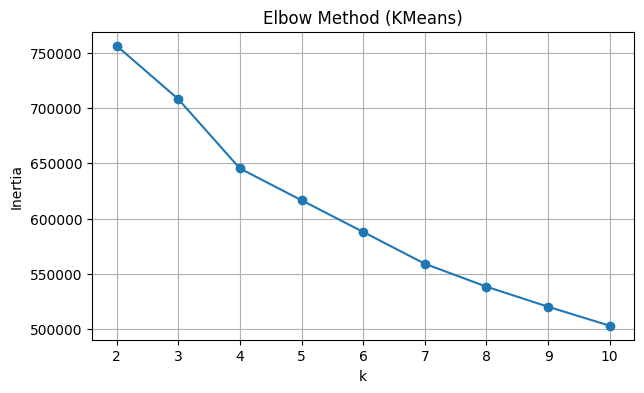

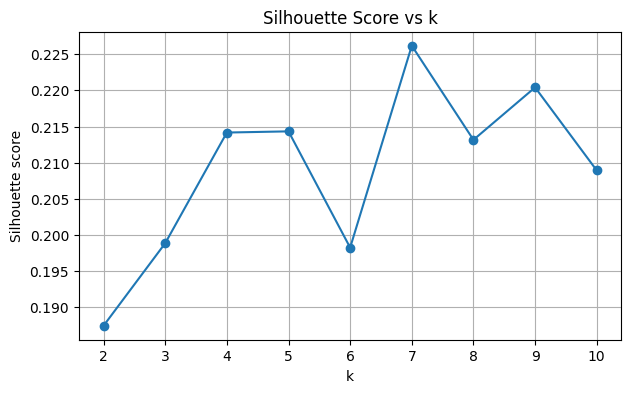

In [ ]:
# # F2) K selection: silhouette + elbow
# K_range = range(2, 11)
# sil_scores = {}
# inertias = {}

# n_samples = len(df_pca)
# for k in K_range:
#     if k >= n_samples:
#         break
#     km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
#     labels = km.fit_predict(df_pca)
#     sil = silhouette_score(df_pca, labels)
#     sil_scores[k] = float(sil)
#     inertias[k] = float(km.inertia_)
#     print(f"k={k}, silhouette={sil:.4f}, inertia={km.inertia_:.2f}")

# best_k = max(sil_scores, key=sil_scores.get)
# print("\nBest k by silhouette:", best_k)
# # best_k = 5  # Uncomment to override manually

# # Plots (shown once)
# plt.figure(figsize=(7, 4))
# plt.plot(list(inertias.keys()), list(inertias.values()), marker="o")
# plt.xlabel("k")
# plt.ylabel("Inertia")
# plt.title("Elbow Method (KMeans)")
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(7, 4))
# plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker="o")
# plt.xlabel("k")
# plt.ylabel("Silhouette score")
# plt.title("Silhouette Score vs k")
# plt.grid(True)
# plt.show()

In [ ]:
# # G1) Train final KMeans
# kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)
# cluster_labels = kmeans.fit_predict(df_pca)

# cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
# print("Cluster counts:")
# display(cluster_counts)

Cluster counts:


0    1756
1     181
2     273
3     462
4    3002
5      12
6    2873
Name: count, dtype: int64

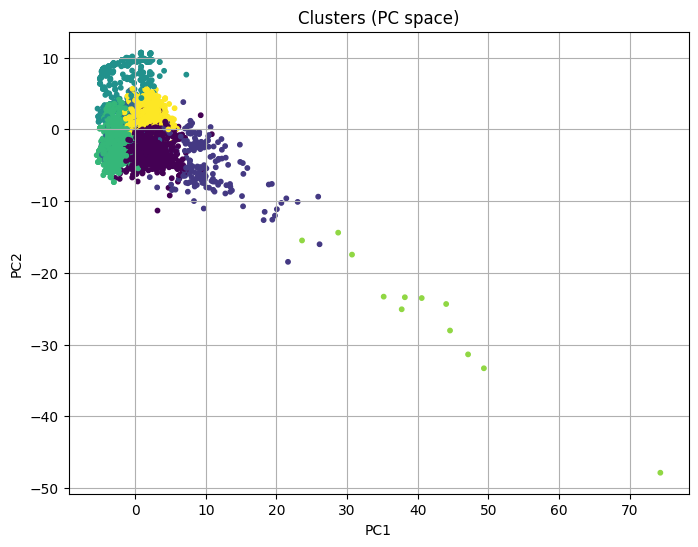

In [ ]:
# # G2) Visualize: PC1 vs PC2 colored by cluster
# if df_pca.shape[1] < 2:
#     raise ValueError("Need at least 2 components to plot PC1 vs PC2.")

# plt.figure(figsize=(8, 6))
# plt.scatter(df_pca["PC1"], df_pca["PC2"], c=cluster_labels, s=10)
# plt.xlabel("PC1")
# plt.ylabel("PC2")
# plt.title("Clusters (PC space)")
# plt.grid(True)
# plt.show()

In [ ]:
# # H) Link clusters back to original data + save
# df_original_with_clusters = df_original.copy()
# df_original_with_clusters["cluster"] = cluster_labels

# df_original_with_clusters.to_csv(OUT_ORIGINAL_WITH_CLUSTERS, index=False)
# print("Saved original dataset with clusters to:", OUT_ORIGINAL_WITH_CLUSTERS)

# df_original_with_clusters.head()

Saved original dataset with clusters to: ../data/processed/original_with_clusters.csv


,DUNS Number,Company Sites,Website,Address Line 1,City,State,State Or Province Abbreviation,Postal Code,Country,Phone Number,Region,Entity Type,Ownership Type,Employees Single Site,Employees Total,Revenue (USD),SIC Code,SIC Description,8-Digit SIC Code,8-Digit SIC Description,NAICS Code,NAICS Description,NACE Rev 2 Code,NACE Rev 2 Description,Ticker,Year Found,Lattitude,Longitude,Parent Company,Parent Street Address,Parents City,Parent State/Province,Parent State/Province Abbreviation,Parent Postal Code,Parent Country/Region,Global Ultimate Company,Global Ultimate Street Address,Global Ultimate City Name,Global Ultimate State/Province,Ultimate State/Province Abbreviation,Global Ultimate Postal Code,Global Ultimate Country Name,Domestic Ultimate Company,Domestic Ultimate Street Address,Domestic Ultimate City Name,Domestic Ultimate State/Province Name,Domestic Ultimate State Abbreviation,Domestic Ultimate Postal Code,Registration Number,Registration Number Type,Company Description,Company Status (Active/Inactive),Legal Status,Corporate Family Members,Is Headquarters,Is Domestic Ultimate,Market Value (USD),Franchise Status,Manufacturing Status,Fiscal Year End,ANZSIC Code,ANZSIC Description,ISIC Rev 4 Code,ISIC Rev 4 Description,IT Budget,IT spend,No. of PC,No. of Desktops,No. of Laptops,No. of Routers,No. of Servers,No. of Storage Devices,cluster
0,639677726,"Zyf Lopsking Material Technology Co., Ltd. No....",NaN,"No.2777 Taidong Road, Panyang Industrial Park,...",Suzhou,Jiangsu,JS,215000.0,China,NaN,Asia,Branch,Private,1.0,1,0,5051,Metals service center,50510000.0,Metals service centers and offices,423510.0,Metal Service Centers and Other Metal Merchant...,4672.0,Wholesale of metals and metal ores,NaN,2023.0,NaN,NaN,"Zyf Lopsking Material Technology Co., Ltd.","No.2777 Taidong Road, Panyang Industrial Park,...",Suzhou,Jiangsu,JS,215143.0,CHINA,"Zyf Lopsking Material Technology Co., Ltd.","No.2777 Taidong Road, Panyang Industrial Park,...",Suzhou,Jiangsu,JS,215143.0,CHINA,"Zyf Lopsking Material Technology Co., Ltd.","No.2777 Taidong Road, Panyang Industrial Park,...",Suzhou,jiangsu,JS,215143.0,NaN,NaN,"Zyf Lopsking Material Technology Co., Ltd. No....",Active,3.0,24,0.0,0.0,0,FALSE,NaN,2031-12-01 00:00:00,3322.0,Metal and Mineral Wholesaling,4662.0,Wholesale of metals and metal ores,0,0,1 to 10,1 to 10,1 to 10,1 to 10,NaN,NaN,4
1,547756179,"Beijing Kaishi Lide Commerce And Trade Co., Ltd.",NaN,"No.306, Building 8, Shuangyushudongli Jia, Hai...",Beijing,Beijing,BJ,100086.0,China,1.082129e+09,Asia,Subsidiary,Private,20.0,20,311166,5651,Ret family clothing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008.0,NaN,NaN,"Zushijie (Beijing) Technology Co., Ltd.","1137, Floor 1011, Building 2, No. West 900 Cou...",Beijing,Beijing,BJ,100000.0,CHINA,"Zushijie (Beijing) Technology Co., Ltd.","1137, Floor 1011, Building 2, No. West 900 Cou...",Beijing,Beijing,BJ,100000.0,CHINA,"Zushijie (Beijing) Technology Co., Ltd.","1137, Floor 1011, Building 2, No. West 900 Cou...",Beijing,beijing,BJ,100000.0,1.101080e+14,NaN,NaN,Active,3.0,2,NaN,NaN,0,NaN,NaN,2031-12-01 00:00:00,NaN,NaN,NaN,NaN,5601,3472,1 to 10,1 to 10,1 to 10,1 to 10,1 to 10,1 to 10,0
2,728834216,Keshan Shengren Potato Industry Processing Co....,NaN,"South of Siduan Road, Xi Street, Keshan Town, ...",Qiqihar,Heilongjiang,HL,161000.0,China,NaN,Asia,Subsidiary,Private,89.0,89,2414036,2037,Mfg frozen fruits/vegetables,20370000.0,Frozen fruits and vegetables,311411.0,"Frozen Fruit, Juice, and Vegetable Manufacturing",NaN,NaN,NaN,2013.0,47.34088,123.96045,"Zuoyuan Group Co., Ltd.","No.,4, No.3, Floor 17, No.596, Huangpu Road, D...",Dalian,Liaoning,NaN,116000.0,CHINA,"Zuoyuan Group Co., Ltd.","No.,4, No.3, Floor 17, No.596, Huangpu Road, D...",Dalian,Liaoning,NaN,116000.0,CHINA,"Zuoyuan Group Co., Ltd.","No.,4, No.3, Floor 17, No.596, Huangpu Road, D...",Dalian,liaoning,NaN,116000.0,2.302291e+14,NaN,Keshan Shengren Potato Industry Processing Co....,Active,3.0,9,NaN,NaN,8280143,NaN,Yes,2031-12-01 00:00:00,NaN,

## Cluster Interpretation Summary

Interpretation should be done on **original features**, not on PC features. Below we build a simple `profile_display` table per cluster:
- cluster size
- means/medians for known numeric columns if present
- % coverage for known flag columns if present
- top value for known categorical columns if present

The code is written to be robust to missing columns (it will only summarize what exists).

In [ ]:
# # I2) Build cluster profile summary on original features
# pd.set_option("display.max_columns", None)
# pd.set_option("display.width", 200)

# candidate_numeric = [
#     "Employees Single Site",
#     "Employees Total",
#     "Revenue (USD)",
#     "Year Found",
#     "Market Value (USD)"
# ]
# numeric_cols = [c for c in candidate_numeric if c in df_original_with_clusters.columns]

# candidate_cats = [
#     "Country",
#     "Region",
#     "Entity Type",
#     "Ownership Type",
#     "NAICS Description",
#     "SIC Description",
#     "Legal Status"
# ]
# cat_cols = [c for c in candidate_cats if c in df_original_with_clusters.columns]

# candidate_flags = ["has_website", "has_phone", "has_address", "has_city", "has_country"]
# flag_cols = [c for c in candidate_flags if c in df_original_with_clusters.columns]

# print("Summary columns used:")
# print("- Numeric:", numeric_cols)
# print("- Categorical:", cat_cols)
# print("- Flags:", flag_cols)

# def top_value(series: pd.Series):
#     s = series.dropna()
#     if len(s) == 0:
#         return None
#     return s.value_counts().index[0]

# profile = df_original_with_clusters.groupby("cluster").agg(size=("cluster", "count"))

# for col in numeric_cols:
#     profile[f"{col}__mean"] = df_original_with_clusters.groupby("cluster")[col].mean()
#     profile[f"{col}__median"] = df_original_with_clusters.groupby("cluster")[col].median()

# for col in flag_cols:
#     profile[f"{col}__pct"] = df_original_with_clusters.groupby("cluster")[col].mean() * 100

# for col in cat_cols:
#     profile[f"{col}__top"] = df_original_with_clusters.groupby("cluster")[col].apply(top_value)

# needed_for_risk = ["has_website", "has_phone", "has_address"]
# if all(c in df_original_with_clusters.columns for c in needed_for_risk):
#     df_original_with_clusters["risk_score"] = (
#         (1 - df_original_with_clusters["has_website"]) +
#         (1 - df_original_with_clusters["has_phone"]) +
#         (1 - df_original_with_clusters["has_address"])
#     )
#     profile["risk_score__mean"] = df_original_with_clusters.groupby("cluster")["risk_score"].mean()

# profile = profile.sort_values("size", ascending=False)

# profile_display = profile.copy()
# for c in profile_display.columns:
#     if "__mean" in c or "__median" in c:
#         profile_display[c] = profile_display[c].round(2)
#     if "__pct" in c:
#         profile_display[c] = profile_display[c].round(1)
#     if "risk_score" in c:
#         profile_display[c] = profile_display[c].round(3)

# profile_display.to_csv(OUT_CLUSTER_PROFILE, index=True)
# print("Saved cluster summary to:", OUT_CLUSTER_PROFILE)

# display(profile_display)

# # Clean report view (subset)
# important_cols = ["size"]
# for col in ["Revenue (USD)__mean", "Revenue (USD)__median", "Employees Total__mean", "Employees Total__median"]:
#     if col in profile_display.columns:
#         important_cols.append(col)
# for col in flag_cols:
#     colname = f"{col}__pct"
#     if colname in profile_display.columns:
#         important_cols.append(colname)
# for col in ["Country__top", "NAICS Description__top", "Ownership Type__top", "Entity Type__top"]:
#     if col in profile_display.columns:
#         important_cols.append(col)
# if "risk_score__mean" in profile_display.columns:
#     important_cols.append("risk_score__mean")

# display(profile_display[important_cols])

Summary columns used:
- Numeric: ['Employees Single Site', 'Employees Total', 'Revenue (USD)', 'Year Found', 'Market Value (USD)']
- Categorical: ['Country', 'Region', 'Entity Type', 'Ownership Type', 'NAICS Description', 'SIC Description', 'Legal Status']
- Flags: []
Saved cluster summary to: ../data/processed/cluster_summary_original_features.csv


,size,Employees Single Site__mean,Employees Single Site__median,Employees Total__mean,Employees Total__median,Revenue (USD)__mean,Revenue (USD)__median,Year Found__mean,Year Found__median,Market Value (USD)__mean,Market Value (USD)__median,Country__top,Region__top,Entity Type__top,Ownership Type__top,NAICS Description__top,SIC Description__top,Legal Status__top
cluster,,,,,,,,,,,,,,,,,,
4,3002,1.21,0.0,1.21,0.0,26219.07,0.0,2019.46,2022.0,82801.93,0.0,China,Asia,Branch,Private,All Other Miscellaneous Store Retailers (excep...,Ret drugs/sundries,3.0
6,2873,21.94,18.0,21.94,18.0,3019025.04,1714112.0,2019.00,2022.0,9778092.30,6675812.0,China,Asia,Subsidiary,Private,Nonclassifiable Establishments,Business services,3.0
0,1756,22.34,11.0,22.34,11.0,11046163.73,1537856.5,2003.55,2004.0,23965914.55,3770215.5,China,Asia,Subsidiary,Private,Nonresidential Property Managers,Nonresidential building operator,3.0
3,462,11.68,1.0,11.68,1.0,1565047.22,806292.0,2008.88,2023.0,4644094.32,849936.0,China,Asia,Subsidiary,Private,Unclassified Establishments,Nonclassified establishment,0.0
2,273,8.75,7.0,8.58,7.0,525642.63,223970.0,2018.58,2022.0,0.00,0.0,China,Asia,Subsidiary,Private,Other Aquaculture,Fish/shellfish farm,3.0
1,181,323.19,207.0,323.19,207.0,23958681.82,5505750.0,2004.47,2003.0,40948848.84,9609642.0,China,Asia,Subsidiary,Private,Offices of Real Estate Agents and Brokers,Real estate agent/manager,3.0
5,12,1817.50,1600.0,1817.50,1600.0,45593069.00,5767998.0,2002.70,2002.0,12411083.42,0.0,China,Asia,Parent,Private,Commercial Banking,Mfg fabricated rubber products,3.0


,size,Revenue (USD)__mean,Revenue (USD)__median,Employees Total__mean,Employees Total__median,Country__top,NAICS Description__top,Ownership Type__top,Entity Type__top
cluster,,,,,,,,,
4,3002,26219.07,0.0,1.21,0.0,China,All Other Miscellaneous Store Retailers (excep...,Private,Branch
6,2873,3019025.04,1714112.0,21.94,18.0,China,Nonclassifiable Establishments,Private,Subsidiary
0,1756,11046163.73,1537856.5,22.34,11.0,China,Nonresidential Property Managers,Private,Subsidiary
3,462,1565047.22,806292.0,11.68,1.0,China,Unclassified Establishments,Private,Subsidiary
2,273,525642.63,223970.0,8.58,7.0,China,Other Aquaculture,Private,Subsidiary
1,181,23958681.82,5505750.0,323.19,207.0,China,Offices of Real Estate Agents and Brokers,Private,Subsidiary
5,12,45593069.00,5767998.0,1817.50,1600.0,China,Commercial Banking,Private,Parent


In [32]:
# J) (Optional) Inspect a single cluster
CLUSTER_TO_VIEW = 0  # change as needed

# Example: show 20 sample rows from the chosen cluster
df_original_with_clusters[df_original_with_clusters["cluster"] == CLUSTER_TO_VIEW].head(20)

,DUNS Number,Company Sites,Website,Address Line 1,City,State,State Or Province Abbreviation,Postal Code,Country,Phone Number,Region,Entity Type,Ownership Type,Employees Single Site,Employees Total,Revenue (USD),SIC Code,SIC Description,8-Digit SIC Code,8-Digit SIC Description,NAICS Code,NAICS Description,NACE Rev 2 Code,NACE Rev 2 Description,Ticker,Year Found,Lattitude,Longitude,Parent Company,Parent Street Address,Parents City,Parent State/Province,Parent State/Province Abbreviation,Parent Postal Code,Parent Country/Region,Global Ultimate Company,Global Ultimate Street Address,Global Ultimate City Name,Global Ultimate State/Province,Ultimate State/Province Abbreviation,Global Ultimate Postal Code,Global Ultimate Country Name,Domestic Ultimate Company,Domestic Ultimate Street Address,Domestic Ultimate City Name,Domestic Ultimate State/Province Name,Domestic Ultimate State Abbreviation,Domestic Ultimate Postal Code,Registration Number,Registration Number Type,Company Description,Company Status (Active/Inactive),Legal Status,Corporate Family Members,Is Headquarters,Is Domestic Ultimate,Market Value (USD),Franchise Status,Manufacturing Status,Fiscal Year End,ANZSIC Code,ANZSIC Description,ISIC Rev 4 Code,ISIC Rev 4 Description,IT Budget,IT spend,No. of PC,No. of Desktops,No. of Laptops,No. of Routers,No. of Servers,No. of Storage Devices,cluster
1,547756179,"Beijing Kaishi Lide Commerce And Trade Co., Ltd.",NaN,"No.306, Building 8, Shuangyushudongli Jia, Hai...",Beijing,Beijing,BJ,100086.0,China,1.082129e+09,Asia,Subsidiary,Private,20.0,20,311166,5651,Ret family clothing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008.0,NaN,NaN,"Zushijie (Beijing) Technology Co., Ltd.","1137, Floor 1011, Building 2, No. West 900 Cou...",Beijing,Beijing,BJ,100000.0,CHINA,"Zushijie (Beijing) Technology Co., Ltd.","1137, Floor 1011, Building 2, No. West 900 Cou...",Beijing,Beijing,BJ,100000.0,CHINA,"Zushijie (Beijing) Technology Co., Ltd.","1137, Floor 1011, Building 2, No. West 900 Cou...",Beijing,beijing,BJ,100000.0,1.101080e+14,NaN,NaN,Active,3.0,2,NaN,NaN,0,NaN,NaN,2031-12-01 00:00:00,NaN,NaN,NaN,NaN,5601,3472,1 to 10,1 to 10,1 to 10,1 to 10,1 to 10,1 to 10,0
2,728834216,Keshan Shengren Potato Industry Processing Co....,NaN,"South of Siduan Road, Xi Street, Keshan Town, ...",Qiqihar,Heilongjiang,HL,161000.0,China,NaN,Asia,Subsidiary,Private,89.0,89,2414036,2037,Mfg frozen fruits/vegetables,20370000.0,Frozen fruits and vegetables,311411.0,"Frozen Fruit, Juice, and Vegetable Manufacturing",NaN,NaN,NaN,2013.0,47.34088,123.96045,"Zuoyuan Group Co., Ltd.","No.,4, No.3, Floor 17, No.596, Huangpu Road, D...",Dalian,Liaoning,NaN,116000.0,CHINA,"Zuoyuan Group Co., Ltd.","No.,4, No.3, Floor 17, No.596, Huangpu Road, D...",Dalian,Liaoning,NaN,116000.0,CHINA,"Zuoyuan Group Co., Ltd.","No.,4, No.3, Floor 17, No.596, Huangpu Road, D...",Dalian,liaoning,NaN,116000.0,2.302291e+14,NaN,Keshan Shengren Potato Industry Processing Co....,Active,3.0,9,NaN,NaN,8280143,NaN,Yes,2031-12-01 00:00:00,NaN,NaN,NaN,NaN,86905,53881,11 to 50,1 to 10,1 to 10,1 to 10,1 to 10,1 to 10,0
4,728889244,Zuoquan County Tianxin Real Estate Development...,NaN,"No.14, Chengyadao Alley, Zuoquan County",Jinzhong,Shanxi,SX,30600.0,China,3.548653e+09,Asia,Parent,Private,2.0,2,1167456,6552,Subdivider/developer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0,NaN,NaN,Zuoquan County Tianxin Real Estate Development...,"No.14, Chengyadao Alley, Zuoquan County",Jinzhong,Shanxi,SX,30600.0,CHINA,Zuoquan County Tianxin Real Estate Development...,"No.14, Chengyadao Alley, Zuoquan County",Jinzhong,Shanxi,SX,30600.0,CHINA,Zuoquan County Tianxin Real Estate Development...,"No.14, Chengyadao Alley, Zuoquan County",Jinzhong,shanxi,SX,30600.0,1.407221e+14,NaN,NaN,Active,3.0,2,NaN,NaN,4121120,NaN,NaN,2031-12-01 00:00:00,NaN,NaN,NaN,NaN,94564,58629,1 to 10,1 to 10,1 to 10,1 to 10,1 to 10,1 to 10,0
7,547765600,Shiliuyuan Branch of Beijing Zuolin Youshe Cat...,dalianhuoshao.com,"No.5, Shiliuyuan NANLI, Fengtai District",Beijing,Beijing,BJ,10